# Deep Learning and Computer Vision Applied to Neuropathology

Elderly people are becoming a rapidly growing proportion of the world’s population14. It
is known that age is an important factor in the development of neurodegenerative
diseases, so as the aging population increases, the ability to detect diseases early will
become even more important. In addition, the biology of the brain is extremely complex, and even
now, our limited understanding of the brain can prevent us from identifying, diagnosing
and treating/curing diseases as quickly as we may need to. This has led to the adoption
of machine learning within life sciences research.

In this project, I develop a convlutional neural network (CNN) that, when given a brain MRI image, classifies the type of tumor. The classification categories are:

- Glioma
- Meningioma
- Pituitary 
- Healthy

An efficient computational classifier can be a useful tool help pathologists accelerate the cancer-type classification process and reduce misclassification.

In [12]:
## Import Necessary libraries
import numpy as np
import os
import PIL
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import random
import matplotlib.pyplot as plt
from IPython import display

In [2]:
tf.__version__ # print tensorflow version

'2.7.0'

In [8]:
_FIGURE_ONE_PATH = '/Users/Jonathan/Desktop/Errythang/MSDAS/Bioinformatics/project/Figure1.png'

In [3]:
tf.config.list_physical_devices() # check that GPU is available

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Below are helper functions I wrote for data loading and preprocessing. 

In [15]:
def load_data(data_dir, image_height, image_width, batch_size):
    """
    loads and splits training data into train and validation sets

    INPUTS: Training data directory path, image shape (height, width), batch size

    OUTPUTS: Training and Validation datasets
    """
    train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset="training",
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size)

    val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset="validation",
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size)

    return train_ds, val_ds


def visualize_data(train_ds):
    """
    displays a 3x3 grid of example training images

    INPUTS: Training dataset
    OUTPUT: 3x3 grid of images
    """
    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(train_ds.class_names[labels[i]])
            plt.axis("off")

CNNs are superior to traditional feed forward neural networks for image analysis in part
because of their dimensionality reduction features. As shown in Figure 1, traditional
neural networks feature input layers, a series of hidden layers and an output layer
where each node (or neuron) in a given hidden layer is connected to all neurons of the
previous layer. Neurons in a given hidden layer are also adjusted independently of the
other neurons in the same layer. This type of architecture is not ideal for images. If an
image has width and height 512 and three color channels, neurons in the first hidden
layer would each have 786,432 (512x512x3) weights. For datasets with thousands or
tens of thousands of images, the amount of parameters quickly becomes infeasible.


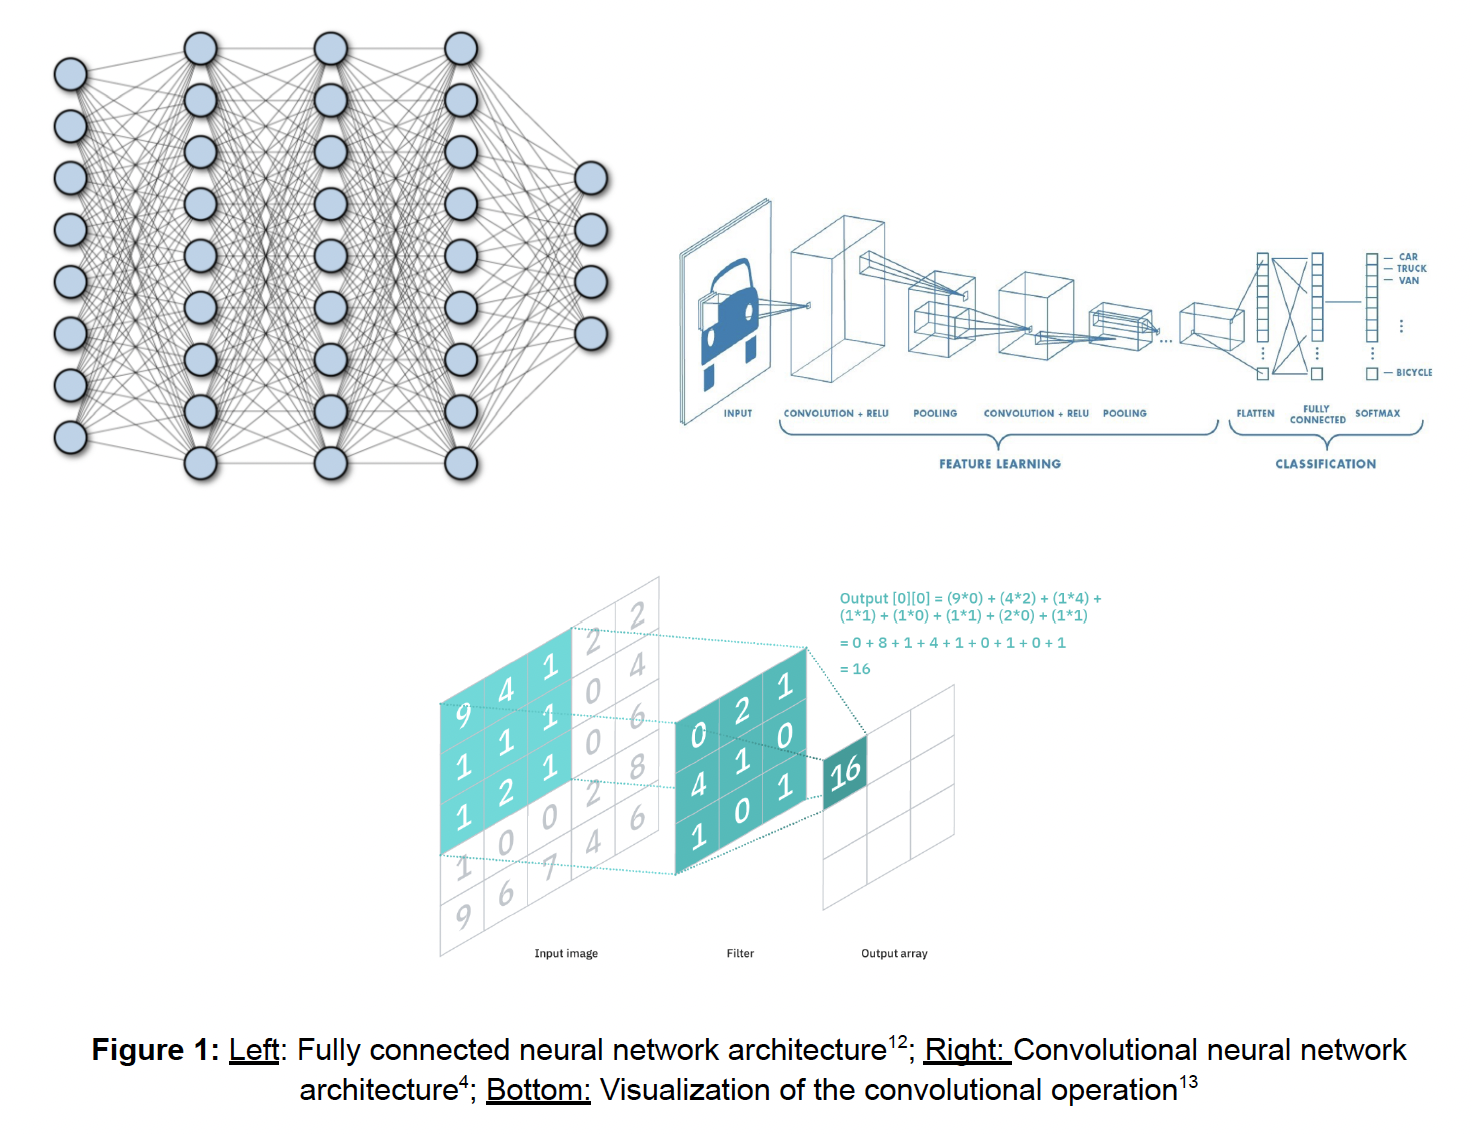



Also shown in Figure 1, the architecture of CNNs features a combination of
convolutional and pooling layers, as well as fully connected layers. Convolutional layers
use a filter (kernel) to extract meaningful features from the image and form the
convolved feature4. Typically the kernel dimensions are 3x3. Features are extracted by
sliding the kernel through each 3x3 region of the input image and taking the dot product
between the kernel and the corresponding region of the input image. The bottom of
Figure 1 shows an example of this feature extraction. The dot products make up the
output array (convolved feature). Unlike with traditional feed-forward networks, the
neurons of the convolved feature are not connected to every neuron in the previous
feature. This is how CNNs reduce the number of parameters while retaining important
information. This dimensionality reduction is taken further with pooling layers. Pooling
reduces dimensionality similarly to the convolutional layers. A filter slides through
regions of the convolved feature and, rather than taking the dot product, outputs the maximum value of the corresponding region. Pooling helps increase training speed and
prevent overfitting.

In [16]:
plt.show(_FIGURE_ONE_PATH)

In [ ]:
def TF_BrainClassifier(class_names, image_height, image_width):
    """
    Building the model (VGG16 implementation with slight modification)
    """
    model = keras.Sequential([
        layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
        layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'),
        layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
        layers.BatchNormalization(),

        layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'),
        layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'),
        layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
        layers.BatchNormalization(),

        layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'),
        layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'),
        layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'),
        layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
        layers.BatchNormalization(),

        layers.Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'),
        layers.Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'),
        layers.Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'),
        layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
        layers.BatchNormalization(),

        layers.Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'),
        layers.Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', 
                        kernel_regularizer='l2', padding='same'),
        layers.Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', 
                        kernel_regularizer='l1', padding='same'),
        
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(len(class_names), activation='softmax')
    ])

    return model

Found 8776 files belonging to 4 classes.
Using 7899 files for training.
Found 8776 files belonging to 4 classes.
Using 877 files for validation.
Image Batch Shape: (64, 128, 128, 3)
Label Batch Shape: (64,)
Class Names: ['glioma', 'meningioma', 'notumor', 'pituitary']


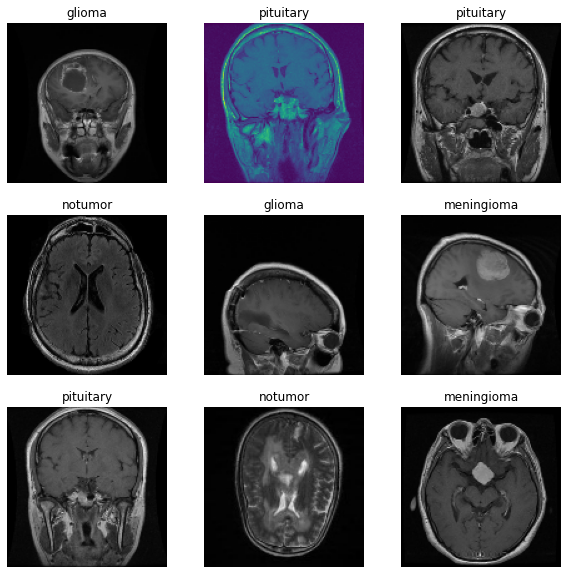

In [16]:
batch_size = 64
image_height = 128
image_width = 128
data_dir = '/Users/Jonathan/Desktop/Errythang/MSDAS/Bioinformatics/project/Brain-Tumor-Classification/data/Training'
train_ds, val_ds = load_data(data_dir, image_height, image_width, batch_size)

for image_batch, labels_batch in train_ds:
    print("Image Batch Shape:", image_batch.shape)
    print("Label Batch Shape:",labels_batch.shape)
    break

print("Class Names:", train_ds.class_names)
visualize_data(train_ds)

In [17]:
#### Model Hyperparameters ####
learning_rate = 0.001

## learning rate decay parameters ##
decay_steps = 110.0   #according to hugging face video, decay steps = len(train_ds) * number of epochs
decay_rate = 0.1
learning_rate_scheduler = keras.optimizers.schedules.InverseTimeDecay(
    learning_rate, decay_steps, decay_rate, staircase=False, name=None)

optimizer = keras.optimizers.Adam(learning_rate=learning_rate_scheduler)
loss = keras.losses.SparseCategoricalCrossentropy()
metrics=['accuracy']
epochs = 25
###############################

model = TF_BrainClassifier(train_ds.class_names, image_height, image_width)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_10 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 conv2d_26 (Conv2D)          (None, 64, 64, 128)      

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

with tf.device('/GPU:0'):
    history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    shuffle=True,
  )

Epoch 1/25


2023-12-12 14:11:13.978326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


124/124 [==============================] - ETA: 0s - loss: 68.9159 - accuracy: 0.5761

2023-12-12 14:12:29.198950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


124/124 [==============================] - 81s 582ms/step - loss: 68.9159 - accuracy: 0.5761 - val_loss: 6.1580 - val_accuracy: 0.4128
Epoch 2/25
124/124 [==============================] - 64s 516ms/step - loss: 4.0890 - accuracy: 0.7257 - val_loss: 3.6408 - val_accuracy: 0.6340
Epoch 3/25
124/124 [==============================] - 64s 517ms/step - loss: 3.0921 - accuracy: 0.7930 - val_loss: 3.0754 - val_accuracy: 0.7252
Epoch 4/25
124/124 [==============================] - 64s 519ms/step - loss: 2.5336 - accuracy: 0.8443 - val_loss: 2.5474 - val_accuracy: 0.7925
Epoch 5/25
124/124 [==============================] - 63s 507ms/step - loss: 2.2555 - accuracy: 0.8716 - val_loss: 2.4948 - val_accuracy: 0.7229
Epoch 6/25
124/124 [==============================] - 62s 502ms/step - loss: 2.0192 - accuracy: 0.8973 - val_loss: 1.9691 - val_accuracy: 0.8905
Epoch 7/25
124/124 [==============================] - 62s 503ms/step - loss: 1.8483 - accuracy: 0.9173 - val_loss: 1.8106 - val_accuracy: 0.

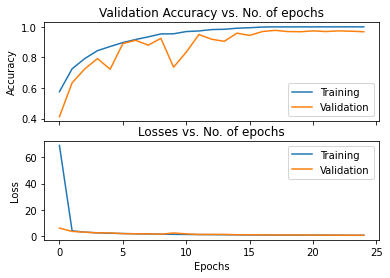

In [19]:
def plot_results(history):
    epoch_lst = list(range(epochs))
    accuracies = history.history['accuracy']
    val_accuracies = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    ax1.plot(epoch_lst, accuracies)
    ax1.plot(epoch_lst, val_accuracies)
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Validation Accuracy vs. No. of epochs')
    ax1.set(ylabel='Accuracy')
    ax2.plot(epoch_lst, loss)
    ax2.plot(epoch_lst, val_loss)
    ax2.set_title('Losses vs. No. of epochs')
    ax2.set(xlabel='Epochs', ylabel='Loss')
    ax2.legend(['Training', 'Validation'])
    plt.show()

plot_results(history)

In [20]:
model.save('/Users/Jonathan/Desktop/Errythang/MSDAS/Bioinformatics/project/GAP_tf_model2.h5')